## Persistence
- Doc : https://docs.langchain.com/oss/python/langgraph/persistence
- Persistence in LangGraph refers to the ability to **save and restore the state of a workflow over time.**

Till point we learned about
- concept of graph
- concept of states

Once workflow will be executed from `START` to `END`, `states` will be updated and once flow will get completed the values of states will be `erased out` which is core behaviour of LangGraph.

In `Persistence` you can save these values and accesible if needed in future.

## Checkpointers in Persistence
- Save value of every stage

## Threads in Persistence
- Doc : https://docs.langchain.com/langsmith/use-threads

In [ ]:
# Library Installation
# pip install -Uq langchain-google-genai langgraph langchain-core google-auth

In [6]:
# Authentication
# Dynamically get credentials and project_id from the current GCP environment
# This avoids hardcoding the ID in your code/GitHub
import google.auth
credentials, project_id = google.auth.default()
# print(f"Successfully authenticated in project: {project_id}")

In [12]:
# Import required libraries
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver

In [13]:
# Initialize the Vertex AI Model with the dynamic projectID
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    project=project_id,
    location="global",
)

In [14]:
class JokeState(TypedDict):
    topic : str
    joke: str
    explaination : str

In [15]:
def generate_joke(state: JokeState) -> JokeState:
    prompt = f"Tell me a joke about {state['topic']}"
    response = llm.invoke(prompt)
    return {'joke':response}


def generate_explaination(state: JokeState) -> JokeState:
    prompt = f"Explain the joke {state['joke']}"
    response = llm.invoke(prompt)
    return {'explaination':response}

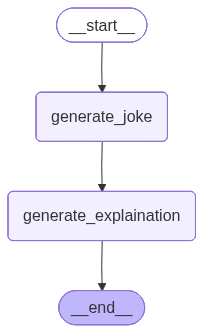

In [16]:
# graph
graph = StateGraph(JokeState)

# nodes
graph.add_node('generate_joke',generate_joke)
graph.add_node('generate_explaination',generate_explaination)

# edges
graph.add_edge(START,'generate_joke')
graph.add_edge('generate_joke','generate_explaination')
graph.add_edge('generate_explaination',END)

# checkpointer
checkpointer = InMemorySaver()

# compile
workflow = graph.compile(checkpointer=checkpointer)
workflow

In [18]:
# The checkpointer (like InMemorySaver) is internally programmed to look specifically at config["configurable"]["thread_id"] to identify the session. It expects the ID to be in that specific "pigeonhole."

config1 = {
    "configurable":{
        "thread_id":1
    }
}

workflow.invoke(
    {
        "topic":"pizza"
    },
    config=config1
)

{'topic': 'pizza',
 'joke': AIMessage(content=[{'type': 'text', 'text': 'What do you call a fake pizza?\n\nA **pepper-phoney**!', 'extras': {'signature': 'Co0NAY89a18H90EbphXiQxUsdBAEXfbC5yyy6h326cnTRLvqIpDBuDzUmUpleN+FX+/ySwJphhG+yu8aYjc1xLfbCmmzWurbEQ/QWYR2NVEQizP3YWb8K4EMQq6pyfCkDDSJFynKCuJsm/zcq0g+KUqcAOQoW6YoJop0NEBoZabkgj5+LVFk9yyQltAIzFNROrtSHuZAgdMPKA/3W+oNB6qzVGV3CODJ2pGwaf9NTaHrHRWNN+OTRC2SRWwKsgzw23V4K/tRGEM+f3waTcel6nGojU6NWO+JqjfGtAPMuU6PF0B8aWHY1Kf9oS6/1U6rMUAsu56qU36wFs/cs6/zvlVjoBvnK6NmWeP2qaKZF4ckOYqIya+wAvek5hiYHFTSbMsmk6cGUEE8/NA14AXJUsUIeKujUQI8/esbRJURD2xibvd9mo3VIb6arYNUbvmcxnLCzwq7pu00q/tDiUCbbZZVXJ3GiY/EhOs4Zl8HNJFCNiRtbUzryZm73hxij0qxcdPMAhXVhaHNi7TX5m92n+0tulzEuTP8aU12ifplWYjvJ6H/tS3f5L4HhnSHTUx6yg5qJniE2e12vuJNTNFnF52yNhAz3wJHmKXLKMLbc4zKXUMIvBg+cZc0soDCcOfE+u0wwdL3dCyA5wZ/Ou5X95wv/nkrNScb1nyv6LcRlQ9sJKcX41YW2CL3wz47MgH7o9A4jN91xA+dO4RUOtrbqK/+uqTpueQ5LSutlWCoqVXM7ZZxfoJGbRXdMqZmOOeHoCUV0GYAEpe7pkyo6VDxy8kkxDZGETHKIjX7KgOypxZhpZ426Hv+P5EPagiO8fiFlO0KbWlUOMYym

In [19]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': AIMessage(content=[{'type': 'text', 'text': 'What do you call a fake pizza?\n\nA **pepper-phoney**!', 'extras': {'signature': 'Co0NAY89a18H90EbphXiQxUsdBAEXfbC5yyy6h326cnTRLvqIpDBuDzUmUpleN+FX+/ySwJphhG+yu8aYjc1xLfbCmmzWurbEQ/QWYR2NVEQizP3YWb8K4EMQq6pyfCkDDSJFynKCuJsm/zcq0g+KUqcAOQoW6YoJop0NEBoZabkgj5+LVFk9yyQltAIzFNROrtSHuZAgdMPKA/3W+oNB6qzVGV3CODJ2pGwaf9NTaHrHRWNN+OTRC2SRWwKsgzw23V4K/tRGEM+f3waTcel6nGojU6NWO+JqjfGtAPMuU6PF0B8aWHY1Kf9oS6/1U6rMUAsu56qU36wFs/cs6/zvlVjoBvnK6NmWeP2qaKZF4ckOYqIya+wAvek5hiYHFTSbMsmk6cGUEE8/NA14AXJUsUIeKujUQI8/esbRJURD2xibvd9mo3VIb6arYNUbvmcxnLCzwq7pu00q/tDiUCbbZZVXJ3GiY/EhOs4Zl8HNJFCNiRtbUzryZm73hxij0qxcdPMAhXVhaHNi7TX5m92n+0tulzEuTP8aU12ifplWYjvJ6H/tS3f5L4HhnSHTUx6yg5qJniE2e12vuJNTNFnF52yNhAz3wJHmKXLKMLbc4zKXUMIvBg+cZc0soDCcOfE+u0wwdL3dCyA5wZ/Ou5X95wv/nkrNScb1nyv6LcRlQ9sJKcX41YW2CL3wz47MgH7o9A4jN91xA+dO4RUOtrbqK/+uqTpueQ5LSutlWCoqVXM7ZZxfoJGbRXdMqZmOOeHoCUV0GYAEpe7pkyo6VDxy8kkxDZGETHKIjX7KgOypxZhpZ426Hv+P5EPa

In [20]:
# to see the intermediete values
list(workflow.get_state_history(config1))
# here you will get different values of `StateSnapshot` which store values of every stage of state
# also it will show what would be the next `node` will callout
# check result from bottom to top of the output
# it also stores the intermedite values of the states

[StateSnapshot(values={'topic': 'pizza', 'joke': AIMessage(content=[{'type': 'text', 'text': 'What do you call a fake pizza?\n\nA **pepper-phoney**!', 'extras': {'signature': 'Co0NAY89a18H90EbphXiQxUsdBAEXfbC5yyy6h326cnTRLvqIpDBuDzUmUpleN+FX+/ySwJphhG+yu8aYjc1xLfbCmmzWurbEQ/QWYR2NVEQizP3YWb8K4EMQq6pyfCkDDSJFynKCuJsm/zcq0g+KUqcAOQoW6YoJop0NEBoZabkgj5+LVFk9yyQltAIzFNROrtSHuZAgdMPKA/3W+oNB6qzVGV3CODJ2pGwaf9NTaHrHRWNN+OTRC2SRWwKsgzw23V4K/tRGEM+f3waTcel6nGojU6NWO+JqjfGtAPMuU6PF0B8aWHY1Kf9oS6/1U6rMUAsu56qU36wFs/cs6/zvlVjoBvnK6NmWeP2qaKZF4ckOYqIya+wAvek5hiYHFTSbMsmk6cGUEE8/NA14AXJUsUIeKujUQI8/esbRJURD2xibvd9mo3VIb6arYNUbvmcxnLCzwq7pu00q/tDiUCbbZZVXJ3GiY/EhOs4Zl8HNJFCNiRtbUzryZm73hxij0qxcdPMAhXVhaHNi7TX5m92n+0tulzEuTP8aU12ifplWYjvJ6H/tS3f5L4HhnSHTUx6yg5qJniE2e12vuJNTNFnF52yNhAz3wJHmKXLKMLbc4zKXUMIvBg+cZc0soDCcOfE+u0wwdL3dCyA5wZ/Ou5X95wv/nkrNScb1nyv6LcRlQ9sJKcX41YW2CL3wz47MgH7o9A4jN91xA+dO4RUOtrbqK/+uqTpueQ5LSutlWCoqVXM7ZZxfoJGbRXdMqZmOOeHoCUV0GYAEpe7pkyo6VDxy8kkxDZGETHKIjX7KgOypxZhpZ426Hv+P5EP

In [23]:
# now lets create a new thread
config2 = {
    "configurable":{
        "thread_id":2
    }
}

workflow.invoke(
    {
        "topic":"pasta"
    },
    config=config2
)

{'topic': 'pasta',
 'joke': AIMessage(content=[{'type': 'text', 'text': 'What do you call a fake noodle?\n\nAn **impasta**!', 'extras': {'signature': 'CtMFAY89a19eli4k38iVNo2kC8KARcXFvkS5whd/UDnsh6NY8ynWsVXBFb1S7Trb4/5p8Rd4L1pAqnB+iNVEMQVri6rxZOQlrA6WbO9yWEZBV8Mzw7MdtDVAiD+eu+Z+qzBw9AIPyFjxaqtFV7NKf7QnNvErgyLb1+WpgrpY7A46rng2hIN08jz+z9PLgKYtKSqoC0caBNZ8Ul2LYq4l50MeQdbsfAw/fwXo47zaCd4TP2vTFnWWK5cyIFIgWOZYePQuv3AhG+/7NkFDOrSUTmzcYgOxJ/zANEeZzhzJG96HFPnoSnsj6vtTchOmK/rQOkLpaQ1Z1LOsgJU7zJRm++xKaw+1hQDYx/hCSF53opX112TVM3w3XEXsX0HYJ+fAS6VJK0BbaK3CLaNe3vxDs060Ua/87uXQDJtnE3X4JtCAdtkFRJRJrI0229td/rpGBHSLlyrN0Or6NcX5RijQhbbrvMYxWE48s4jiOLhP/5SmNXtRujQi/zsMubRay4P7YaY3YlPg3NELfCPJMsXH2A/FdaOwxoOdWjLrUMPfc9oqEiDDOzaODMPGtrTWbllqlOrJVerRlNFxYG+Su5hEtFH8n4NnyvgbePVBTfsb/Ok8L1R0QBTR7b11Jg6iAI3Yw66x/7wwMbxOWmfJgk+c7LOBKw4SKklHnRZUD48uyrAQkqP73V3VzbbNiI1w+53xHSM9X+p4lzGOjYxp0sYyVu7aN5E1HmbLsIogeCMCqbAuAWYbhqbEpf25RDEbOxCbmx8ri/QVt8tqYyUvhLPya8I9OPlS6I2xdr0M4N/TVzTqmFpS0jOFkmrF3qecdqMxHO8bn6GOHZjS99U5F

In [24]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': AIMessage(content=[{'type': 'text', 'text': 'What do you call a fake noodle?\n\nAn **impasta**!', 'extras': {'signature': 'CtMFAY89a19eli4k38iVNo2kC8KARcXFvkS5whd/UDnsh6NY8ynWsVXBFb1S7Trb4/5p8Rd4L1pAqnB+iNVEMQVri6rxZOQlrA6WbO9yWEZBV8Mzw7MdtDVAiD+eu+Z+qzBw9AIPyFjxaqtFV7NKf7QnNvErgyLb1+WpgrpY7A46rng2hIN08jz+z9PLgKYtKSqoC0caBNZ8Ul2LYq4l50MeQdbsfAw/fwXo47zaCd4TP2vTFnWWK5cyIFIgWOZYePQuv3AhG+/7NkFDOrSUTmzcYgOxJ/zANEeZzhzJG96HFPnoSnsj6vtTchOmK/rQOkLpaQ1Z1LOsgJU7zJRm++xKaw+1hQDYx/hCSF53opX112TVM3w3XEXsX0HYJ+fAS6VJK0BbaK3CLaNe3vxDs060Ua/87uXQDJtnE3X4JtCAdtkFRJRJrI0229td/rpGBHSLlyrN0Or6NcX5RijQhbbrvMYxWE48s4jiOLhP/5SmNXtRujQi/zsMubRay4P7YaY3YlPg3NELfCPJMsXH2A/FdaOwxoOdWjLrUMPfc9oqEiDDOzaODMPGtrTWbllqlOrJVerRlNFxYG+Su5hEtFH8n4NnyvgbePVBTfsb/Ok8L1R0QBTR7b11Jg6iAI3Yw66x/7wwMbxOWmfJgk+c7LOBKw4SKklHnRZUD48uyrAQkqP73V3VzbbNiI1w+53xHSM9X+p4lzGOjYxp0sYyVu7aN5E1HmbLsIogeCMCqbAuAWYbhqbEpf25RDEbOxCbmx8ri/QVt8tqYyUvhLPya8I9OPlS6I2xdr0M4N/TVzTqmFpS0jOFkmrF3qecd

In [25]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': AIMessage(content=[{'type': 'text', 'text': 'What do you call a fake noodle?\n\nAn **impasta**!', 'extras': {'signature': 'CtMFAY89a19eli4k38iVNo2kC8KARcXFvkS5whd/UDnsh6NY8ynWsVXBFb1S7Trb4/5p8Rd4L1pAqnB+iNVEMQVri6rxZOQlrA6WbO9yWEZBV8Mzw7MdtDVAiD+eu+Z+qzBw9AIPyFjxaqtFV7NKf7QnNvErgyLb1+WpgrpY7A46rng2hIN08jz+z9PLgKYtKSqoC0caBNZ8Ul2LYq4l50MeQdbsfAw/fwXo47zaCd4TP2vTFnWWK5cyIFIgWOZYePQuv3AhG+/7NkFDOrSUTmzcYgOxJ/zANEeZzhzJG96HFPnoSnsj6vtTchOmK/rQOkLpaQ1Z1LOsgJU7zJRm++xKaw+1hQDYx/hCSF53opX112TVM3w3XEXsX0HYJ+fAS6VJK0BbaK3CLaNe3vxDs060Ua/87uXQDJtnE3X4JtCAdtkFRJRJrI0229td/rpGBHSLlyrN0Or6NcX5RijQhbbrvMYxWE48s4jiOLhP/5SmNXtRujQi/zsMubRay4P7YaY3YlPg3NELfCPJMsXH2A/FdaOwxoOdWjLrUMPfc9oqEiDDOzaODMPGtrTWbllqlOrJVerRlNFxYG+Su5hEtFH8n4NnyvgbePVBTfsb/Ok8L1R0QBTR7b11Jg6iAI3Yw66x/7wwMbxOWmfJgk+c7LOBKw4SKklHnRZUD48uyrAQkqP73V3VzbbNiI1w+53xHSM9X+p4lzGOjYxp0sYyVu7aN5E1HmbLsIogeCMCqbAuAWYbhqbEpf25RDEbOxCbmx8ri/QVt8tqYyUvhLPya8I9OPlS6I2xdr0M4N/TVzTqmFpS0jOFkmrF3qec

## Benefits of Persistence:
- **can implement short term memory**
    - in last code we have implemented short term memory concern with `config` as ut storing name, sum into the memory till machine resource is up-end running

- **can implement fault tollerence**
    - during the workflow at any stage if it got broken down, lets say at `node 3` the previous executed information is stored and can be initite the workflow again from `node 3` instead starting for scrach to reexceute as we are storing value of each state at every node
    - example as while invoking the workflow we are passing some inpute like in above we passed `topic` and at any node if it got failed then while running again the flow we will not initiae it from start means we will not pass any input the workflow instead will pass `None` along with the config in which `thread_id` is present which can correctlate the previous execution steps and collect needed values and continue the flow till END

- **HITL (Human In The Loop)**
    - Lets suppose we have created a social media post using LLM however before posting it online we need Human to review so now flow is waiting for for HITL confirmation but till that flow can't stay in active state and consume resources
    - so to achive this as we saw Persistence will store value of each `node` and will resume the flow once inpute recieved from Human.

- **Time Travel**
    - replay the workflow execution
    - that means we can go to at any particular node and replay the execution from that node
    - this is very helpful while debugging the state of nodes
    - while working with checkpoints a corresponding ID is getting generated which is used in this time travel concept
    

In [27]:
# Implement Time Travel

# will get a state of one checkpoint_id
workflow.get_state(
    {
        "configurable":{
            "thread_id":"1",
            "checkpoint_id":"1f0f3e29-6e7d-663e-8000-c1242fd92b4b"
        }
    }
)

StateSnapshot(values={'topic': 'programming'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0f3e29-6e7d-663e-8000-c1242fd92b4b'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-17T20:24:56.841969+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f3e29-6e77-65f8-bfff-b8fe820565b2'}}, tasks=(PregelTask(id='886b17c3-5087-6b74-4701-cc5d8a37a030', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': AIMessage(content=[{'type': 'text', 'text': 'A programmer’s wife tells him, "While you’re at the store, get some milk. And if they have eggs, get a dozen."\n\nThe programmer returns with 12 cartons of milk.\n\nHis wife asks, "Why on earth did you buy 12 cartons of milk?"\n\nHe replies, "They had eggs."', 'extras': {'signature': 'CsMRAY89a18/KNnsGhHNBz4EPS6iBYLaayv5mB3TDah6mroAjznuPh6iWP8PMcpoOauJhL+xaCwTagA6X+Wc

In [29]:
# now will execute the workflow from here one
workflow.invoke(
    None,
    {
        "configurable":{
            "thread_id":"1",
            "checkpoint_id":"1f0f3e29-6e7d-663e-8000-c1242fd92b4b"
        }
    }
)

{'topic': 'programming',
 'joke': AIMessage(content=[{'type': 'text', 'text': 'A programmer’s wife tells him, "While you\'re at the grocery store, buy a loaf of bread, and if they have eggs, get a dozen."\n\nThe programmer returns home with 13 loaves of bread.\n\nHis wife screams, "Why on earth did you buy thirteen loaves of bread?!"\n\nThe programmer replies, "They had eggs."', 'extras': {'signature': 'CosPAY89a1/lzT10hL5qefgA7UGDeg/GvZQFINsBqpBJeKIL1ChqAWFpUdKoeE2kvT3Z9wjqtm6Ky2j4V+TUjlnEDfDM/yL+xpM4nTNLTB+g1cwQcUlBp9++qejzJmD3y95c+9QTDM96snYHUlmwXgSr+VZyVX42b82ua9XPuRqCzF4u3zpnW3Oc6RPMYKzTP02D/TaLGem5zfWKjMWfntaWug35WbZ4c0vvtVVFBY05tEli2ZkVQ/XgSuHD9IZWGGNCyVuGhAllHhzztrSF5h+ritFx6Xtl3F5TiCAbGv2cnvzNureYwzmY0JdM2pTrsY/Wayh0t6c1K0/RK/7CtX8Nv1reNGe5FF79sQAzTir1sju4I3ARzmVPwyVpbXae+YEAUnSjuTZqPh/VirPYaF6Lj+Dtbs0sbddi6E0J5BFYwVCeKiavywp2u6EaMx3dJiBEubM5z54rMOq37PDYXeZbZY7FyJdQw3HTz4yh69fKq0LB1uZ7vk9Sssm5LG6iE6S38UX9Dr9mxjoXjiRgC1d8UlkiVh7XnxNfo6S23ZmvJUepZU9hE9VZ/bW3voPYe8ql2A6h8wOQyWm9l

In [31]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'programming', 'joke': AIMessage(content=[{'type': 'text', 'text': 'A programmer’s wife tells him, "While you\'re at the grocery store, buy a loaf of bread, and if they have eggs, get a dozen."\n\nThe programmer returns home with 13 loaves of bread.\n\nHis wife screams, "Why on earth did you buy thirteen loaves of bread?!"\n\nThe programmer replies, "They had eggs."', 'extras': {'signature': 'CosPAY89a1/lzT10hL5qefgA7UGDeg/GvZQFINsBqpBJeKIL1ChqAWFpUdKoeE2kvT3Z9wjqtm6Ky2j4V+TUjlnEDfDM/yL+xpM4nTNLTB+g1cwQcUlBp9++qejzJmD3y95c+9QTDM96snYHUlmwXgSr+VZyVX42b82ua9XPuRqCzF4u3zpnW3Oc6RPMYKzTP02D/TaLGem5zfWKjMWfntaWug35WbZ4c0vvtVVFBY05tEli2ZkVQ/XgSuHD9IZWGGNCyVuGhAllHhzztrSF5h+ritFx6Xtl3F5TiCAbGv2cnvzNureYwzmY0JdM2pTrsY/Wayh0t6c1K0/RK/7CtX8Nv1reNGe5FF79sQAzTir1sju4I3ARzmVPwyVpbXae+YEAUnSjuTZqPh/VirPYaF6Lj+Dtbs0sbddi6E0J5BFYwVCeKiavywp2u6EaMx3dJiBEubM5z54rMOq37PDYXeZbZY7FyJdQw3HTz4yh69fKq0LB1uZ7vk9Sssm5LG6iE6S38UX9Dr9mxjoXjiRgC1d8UlkiVh7XnxNfo6S23ZmvJUepZU9hE9VZ/bW3

In [36]:
# Update the state
workflow.update_state(
    {
        "configurable":{
            "thread_id":"1",
            "checkpoint_id":"1f0f3e29-6e7d-663e-8000-c1242fd92b4b",
            "checkpoint_ns": ""
        }
    },
    {
        "topic":"samosa"
    }
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0f463d-2134-6918-8001-4d15f13715b3'}}

In [34]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f4633-6b6a-6d68-8001-1bb7a318bdf3'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2026-01-18T11:45:40.536640+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f3e29-6e7d-663e-8000-c1242fd92b4b'}}, tasks=(PregelTask(id='61df58b4-b1cb-fb38-f667-42415a089cf5', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'programming', 'joke': AIMessage(content=[{'type': 'text', 'text': 'A programmer’s wife tells him, "While you\'re at the grocery store, buy a loaf of bread, and if they have eggs, get a dozen."\n\nThe programmer returns home with 13 loaves of bread.\n\nHis wife screams, "Why on earth did you buy thirteen loaves of bread?!"\n\nThe programmer repli

In [37]:
# now will again execute the workflow
# note that this time topic value is `samosa`
workflow.invoke(
    None,
    {
        "configurable":{
            "thread_id":"1",
            "checkpoint_id":"1f0f463d-2134-6918-8001-4d15f13715b3" #make sure to update this ID generated before while running `update_state` from workflow
        }
    }
)

{'topic': 'samosa',
 'joke': AIMessage(content=[{'type': 'text', 'text': 'Why was the samosa so good at geometry?\n\nBecause it had all the **right angles**!', 'extras': {'signature': 'CuARAY89a19CvjRExrA7QBI3QMuKDJxS77mYfWhjYEWsjvtAam5uavqAYSftJJeIt6dDm01ptEM/Z1fuh8e9LfvtldmvAY0xjz8v3t0A0CERzyu0/dN+jPUqdXWO/DmhYUA7w2XH6NIMuajFJc6KYHocE3sTenwrkVhNU9MVQPR8+SiwPajpu4Y7G9YDAs2Tok43iT9Nv37uzAnQ7vbGhn3akXAR7UdjlyKMZUBSAv6+juBMg5PxU3RsZNwnlkYv6x0Gidg41DOMgTDGSSdBsT7YUEMW8S+BtVDcg2S96SYjBd9MHgoHN6ZmecFHbHvC/dyXI9fzLmDNXb7R7AJ0vt1UsvclkDOKiTn/hVU/XIU2w2TpEXjgLj1BmIm7SJA17tkGI3PMMbdJOOktXMweMl7Oyk1gCcq1bSbjTPCDWCnabdJsvbCE7q7tUN/leQUtHCtAHAvJzfDE0lFKQuSMSV7VHeDz1Ab68hzhz3lDngmLBaRrRcj6nTU/5Gx7B2wUX4rPsEA7TgbbkgnfjxJ7At+9xSaU/EBqaqRobj/fwQ5H1OQ7CSrR3AaowiChyF/HG/ySBdzYjJanoKHPe1imDv8sPpvPtRCiAnXywkHeI6Nf6GU2zBv57LxhqrwDd9tq5OZdjAnF8MD5vTMF3XhY1BpD1qb/q1D6PmggrWour/azNB0egy02N7uWDcLn1rtK4JD0vM50gs+M9bFu2huvGVC4jIp6nANhLUPy4c/kNyJip9mjfozE1pNYOjFKXTQlM9rGUHkrpNRnZicPp1+FHjB5jxecNx/0Noaev7Advy2T30p

In [38]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa', 'joke': AIMessage(content=[{'type': 'text', 'text': 'Why was the samosa so good at geometry?\n\nBecause it had all the **right angles**!', 'extras': {'signature': 'CuARAY89a19CvjRExrA7QBI3QMuKDJxS77mYfWhjYEWsjvtAam5uavqAYSftJJeIt6dDm01ptEM/Z1fuh8e9LfvtldmvAY0xjz8v3t0A0CERzyu0/dN+jPUqdXWO/DmhYUA7w2XH6NIMuajFJc6KYHocE3sTenwrkVhNU9MVQPR8+SiwPajpu4Y7G9YDAs2Tok43iT9Nv37uzAnQ7vbGhn3akXAR7UdjlyKMZUBSAv6+juBMg5PxU3RsZNwnlkYv6x0Gidg41DOMgTDGSSdBsT7YUEMW8S+BtVDcg2S96SYjBd9MHgoHN6ZmecFHbHvC/dyXI9fzLmDNXb7R7AJ0vt1UsvclkDOKiTn/hVU/XIU2w2TpEXjgLj1BmIm7SJA17tkGI3PMMbdJOOktXMweMl7Oyk1gCcq1bSbjTPCDWCnabdJsvbCE7q7tUN/leQUtHCtAHAvJzfDE0lFKQuSMSV7VHeDz1Ab68hzhz3lDngmLBaRrRcj6nTU/5Gx7B2wUX4rPsEA7TgbbkgnfjxJ7At+9xSaU/EBqaqRobj/fwQ5H1OQ7CSrR3AaowiChyF/HG/ySBdzYjJanoKHPe1imDv8sPpvPtRCiAnXywkHeI6Nf6GU2zBv57LxhqrwDd9tq5OZdjAnF8MD5vTMF3XhY1BpD1qb/q1D6PmggrWour/azNB0egy02N7uWDcLn1rtK4JD0vM50gs+M9bFu2huvGVC4jIp6nANhLUPy4c/kNyJip9mjfozE1pNYOjFKXTQlM9rGUHkrpNRnZicPp1+FHjB5jx